## Ti2N

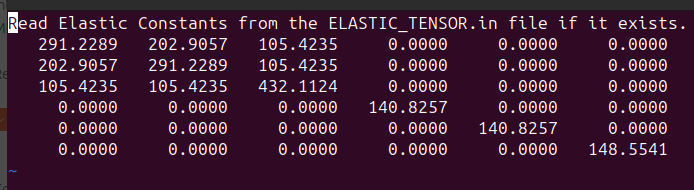

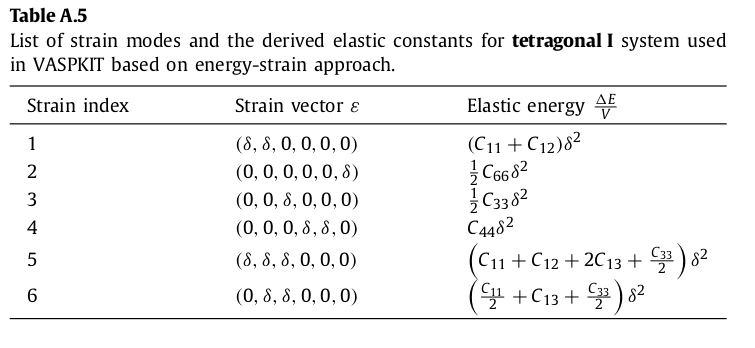

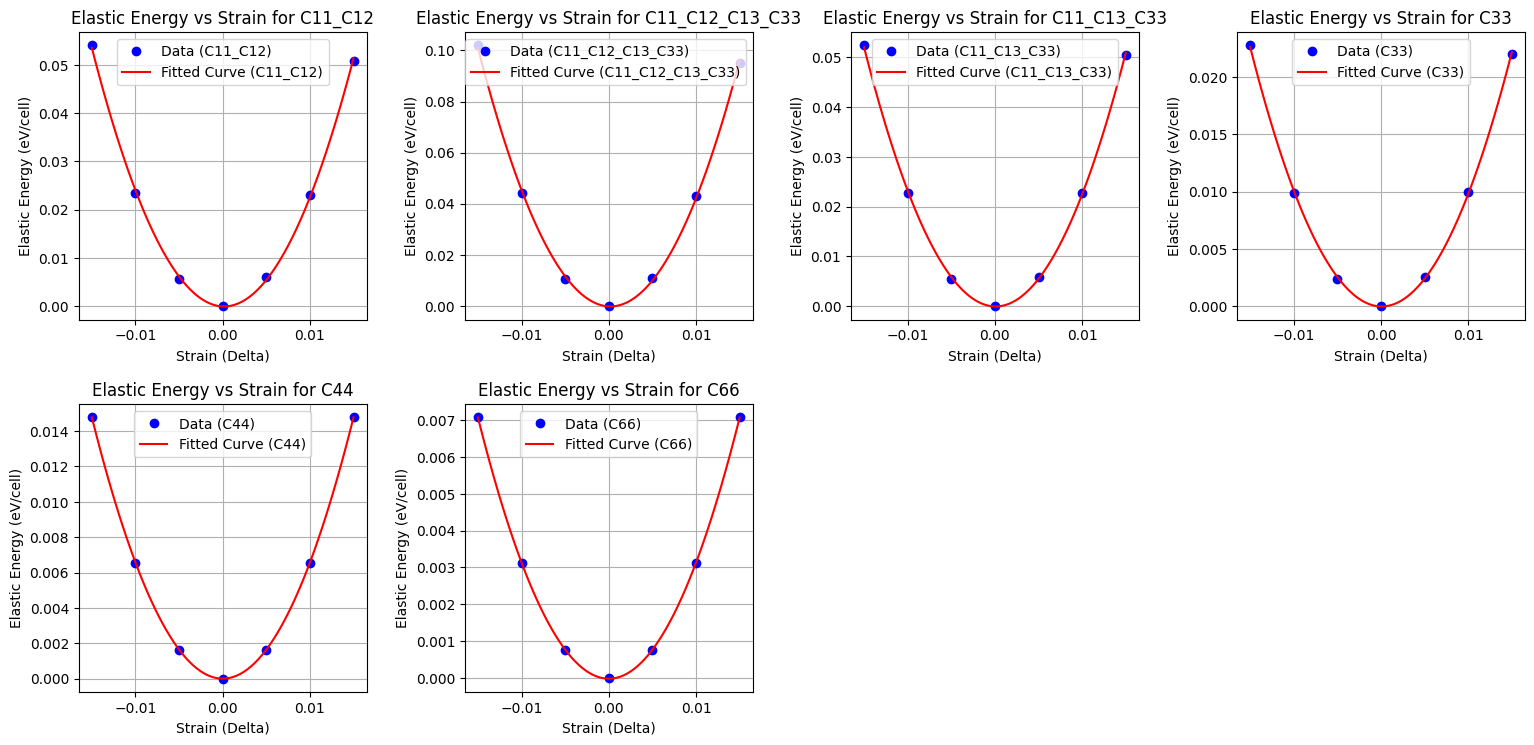

500.9479736368832
942.3407194605629
491.64205387105113
428.10094125429526
141.03583863461907
135.34685956476332


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('energy_collab_potential_final')

# Extract the strain values
strain_values = data['Strain_values']

# Define formulas for each column (placeholder formulas here—replace as needed)
formulas = {
    'C11_C12': lambda coef:  1 * coef,                   # Example formula: 1 * (C11+C12) * delta^2
    'C11_C12_C13_C33': lambda coef: 1 * coef,             # Example formula: 1 * (C11 + C12 + 2C13 + C33/2) * delta^2
    'C11_C13_C33': lambda coef: 1 * coef,             # Example formula: 1 * (C11/2 + C13 + C33/2) * delta^2
    'C33': lambda coef: 2 * coef,                   # Example formula: 1/2 * (C33) * delta^2
    'C44': lambda coef: 1 * coef,                   # Example formula: 1 * (C44) * delta^2
    'C66': lambda coef: 2 * coef,                   # Example formula: 1/2 * (C66) * delta^2
}

# Prepare to store computed C-values
C_values = {}
V0 = 74.61

# Define subplot grid dimensions
num_columns = len(data.columns) - 1  # Excluding 'Strain_values'
num_rows = (num_columns + 3) // 4  # For a 3x4 grid layout, adjust as needed

fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 4))
fig.tight_layout(pad=4.0)  # Adjust spacing between subplots

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over each column in the DataFrame (excluding 'Strain_values')
for i, column in enumerate(data.columns[1:]):
    # Fit a quadratic polynomial to the data
    coefficients = np.polyfit(strain_values, data[column], 2)
    
    # Apply the specific formula for each column
    if column in formulas:
        C_value = formulas[column](coefficients[0])
        C_values[column] = C_value * (160.21766/V0)
    else:
        print(f"No formula defined for {column}, skipping.")
        continue

    # Generate values for the fitted curve
    strain_fit = np.linspace(strain_values.min(), strain_values.max(), 100)
    energy_fit = np.polyval(coefficients, strain_fit)

    # Plot the data and the fitted curve in a subplot
    axs[i].plot(strain_values, data[column], 'o', label=f"Data ({column})", color="blue")
    axs[i].plot(strain_fit, energy_fit, '-', label=f"Fitted Curve ({column})", color="red")
    axs[i].set_title(f"Elastic Energy vs Strain for {column}")
    axs[i].set_xlabel("Strain (Delta)")
    axs[i].set_ylabel("Elastic Energy (eV/cell)")
    axs[i].legend()
    axs[i].grid(True)

# Remove any empty subplots (if number of columns < grid size)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and show the plot
plt.show()

# Print out the calculated C-values
for key, value in C_values.items():
    #print(f"{key} C-value: {value} GPa")
    print(f"{value}")

## Potential

In [1]:
from sympy import symbols, Eq, solve, Matrix

# Define the variables
C11, C12, C22, C23, C31, C33, C44, C51, C52, C53, C55, C64, C66 = symbols('C11 C12 C22 C23 C31 C33 C44 C51 C52 C53 C55 C64 C66')

# Define the equations
eq1 = Eq(C11 + C12 - 500.947973636883, 0)  
eq2 = Eq(C66 - 135.346859564763, 0)
eq3 = Eq(C44 -  141.035838634619, 0)
eq4 = Eq(C33 - 428.100941254295, 0)
eq5 = Eq(C11 + C12 + 2 * C31 + C33/2 - 942.340719460563, 0)
eq6 = Eq(C11/2 + C31 + C33/2 - 491.642053871051, 0)

# Solve the equations
solution = solve([eq1, eq2, eq3, eq4, eq5, eq6], (C11, C12, C31, C33, C44, C66))

# Add derived values
solution[C22] = solution[C11]
solution[C23] = solution[C31]
solution[C55] = solution[C44]

# Construct the elastic tensor with substituted values
elastic_tensor = Matrix([
    [C11, C12, C31, 0,    0,    0],
    [C12, C22, C23, 0,    0,    0],
    [C31, C23, C33, 0,    0,    0],
    [0,   0,   0,   C44,  0,    0],
    [0,   0,   0,   0,    C55,  0],
    [0,   0,   0,   0,    0,    C66]
]).subs(solution)

# Compute the compliance matrix
compliance_matrix = elastic_tensor.inv()

# Extract substituted compliance values
compliance_values = compliance_matrix.subs(solution)
S11 = compliance_values[0, 0]
S12 = compliance_values[0, 1]
S66 = compliance_values[5, 5]
S33 = compliance_values[2, 2]
S44 = compliance_values[3, 3]
S31 = compliance_values[2, 0]
S22 = compliance_values[1, 1]
S23 = compliance_values[1, 2]
S55 = compliance_values[4, 4]

# Voigt bounds equations
KV = ((solution[C11] + solution[C22] + solution[C33] + 
       2 * (solution[C12] + solution[C23] + solution[C31])) / 9)
GV = ((solution[C11] + solution[C22] + solution[C33]) - 
      (solution[C12] + solution[C23] + solution[C31]) + 
      4 * (solution[C44] + solution[C55] + solution[C66])) / 15

# Reuss bounds equations
KR = 1 / (S11 + S22 + S33 + 2 * (S12 + S23 + S31))
GR = 15 / (4 * (S11 + S22 + S33) - 4 * (S12 + S23 + S31) + 3 * (S44 + S55 + S66))

# Voigt-Reuss-Hill averages
K_VRH = (KV + KR) / 2
G_VRH = (GV + GR) / 2

# Print results
print("Solution:", solution)
print(f"Compliance Matrix:\n{compliance_values}")
print(f"Voigt Bulk Modulus, KV: {KV}")
print(f"Voigt Shear Modulus, GV: {GV}")
print(f"Reuss Bulk Modulus, KR: {KR}")
print(f"Reuss Shear Modulus, GR: {GR}")
print(f"K-VRH: {K_VRH}")
print(f"G-VRH: {G_VRH}")

Solution: {C11: 327.840891291274, C12: 173.107082345608, C31: 113.671137598266, C33: 428.100941254295, C44: 141.035838634619, C66: 135.346859564763, C22: 327.840891291274, C23: 113.671137598266, C55: 141.035838634619}
Compliance Matrix:
Matrix([[0.00436621552243278, -0.00209649619399078, -0.000602665290426259, 0, 0, 0], [-0.00209649619399078, 0.00436621552243278, -0.000602665290426259, 0, 0, 0], [-0.000602665290426259, -0.000602665290426259, 0.00265594206585052, 0, 0, 0], [0, 0, 0, 0.00709039638209048, 0, 0], [0, 0, 0, 0, 0.00709039638209048, 0], [0, 0, 0, 0, 0, 0.00738842410688889]])
Voigt Bulk Modulus, KV: 209.409048769014
Voigt Shear Modulus, GV: 156.867167575380
Reuss Bulk Modulus, KR: 208.998664863201
Reuss Shear Modulus, GR: 121.488525863206
K-VRH: 209.203856816107
G-VRH: 139.177846719293
